# Laboratorio 6

Integrantes:  
Andres de la Roca  

Jun Woo Lee

## 1. Preparacion de los datos

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import imageio
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.utils import array_to_img, img_to_array, load_img
from numpy.random import randn
from numpy.random import randint
import tensorflow as tf

In [77]:
# Parametros
n_images = 5000
batch_size = 128
latent_dim = 100
n_epoch = 10
img_shape = (128, 128, 3)

In [78]:
data_dir = '../input/celeba-dataset/img_align_celeba/img_align_celeba/' 
data_dir = 'CelebA/img_align_celeba/img_align_celeba/'
images = os.listdir(data_dir)
images = images[:n_images]

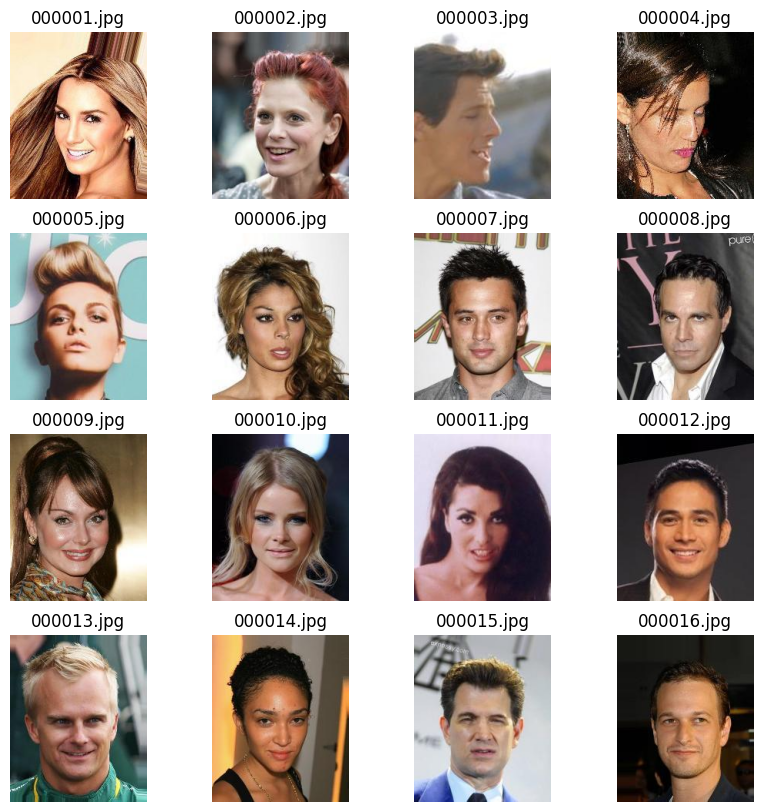

In [79]:
# Mostrar imagenes
plt.figure(figsize=(10,10))
for i, name in enumerate(images[:16]):
    plt.subplot(4, 4, i + 1)
    img = plt.imread(data_dir + '/' + name)
    plt.imshow(img)
    plt.title(name)
    plt.axis('off')

In [80]:
def get_data(data_path) :
    X = []
    for filename in data_path :
        img = img_to_array(load_img(data_dir + "/" + filename, target_size = img_shape[:2]))
        X.append(img)
    X = np.array(X).astype('float32')
    X = X / 255
    return X

dataset = get_data(images)

## 2. Implementacion de la GAN

### Discriminador

In [81]:
def define_discriminator(in_shape=(128,128,3)):
    model = Sequential()
    # normal
    model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 64x64
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

### Generador

In [82]:
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 128 * 8 * 8
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 128)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
    return model

def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y

### GAN

In [83]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

def get_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y

def show_generated(generated,epoch, n=5):

    plt.figure(figsize=(10,10))
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        plt.imshow(generated[i])
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+1))
    plt.show()    

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    X_real, y_real = get_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy [real: %.0f%%, fake: %.0f%%]' % (acc_real*100, acc_fake*100))
    show_generated(x_fake, epoch)  

## 3. Entrenamiento de la GAN

In [84]:
def train(g_model, d_model, gan_model, dataset, latent_dim=100, n_epochs=5, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    start = time.time()
    for i in range(n_epochs):
        
        for j in range(bat_per_epo):
            X_real, y_real = get_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
        print('Epoch: %d,  Loss: D_real = %.3f, D_fake = %.3f,  G = %.3f' %   (i+1, d_loss1, d_loss2, g_loss))
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)     
    print ('Total time for training {} epochs is {} sec'.format(n_epochs, (time.time()-start)))

2/2 [==============================] - 2s 1s/step
Epoch: 1,  Loss: D_real = 0.074, D_fake = 0.194,  G = 3.609
2/2 [==============================] - 2s 1s/step
Epoch: 2,  Loss: D_real = 0.241, D_fake = 1.218,  G = 0.530
2/2 [==============================] - 2s 1s/step
Epoch: 3,  Loss: D_real = 0.183, D_fake = 0.120,  G = 3.473
2/2 [==============================] - 2s 1s/step
Epoch: 4,  Loss: D_real = 0.795, D_fake = 0.534,  G = 2.552
2/2 [==============================] - 2s 1s/step
Epoch: 5,  Loss: D_real = 0.516, D_fake = 0.445,  G = 2.015
2/2 [==============================] - 2s 1s/step
Epoch: 6,  Loss: D_real = 0.508, D_fake = 0.533,  G = 1.155
2/2 [==============================] - 2s 1s/step
Epoch: 7,  Loss: D_real = 0.465, D_fake = 0.267,  G = 1.900
2/2 [==============================] - 2s 1s/step
Epoch: 8,  Loss: D_real = 0.428, D_fake = 0.377,  G = 1.576
2/2 [==============================] - 2s 1s/step
Epoch: 9,  Loss: D_real = 0.434, D_fake = 0.419,  G = 1.777
2/2 [=====

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Accuracy [real: 76%, fake: 99%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

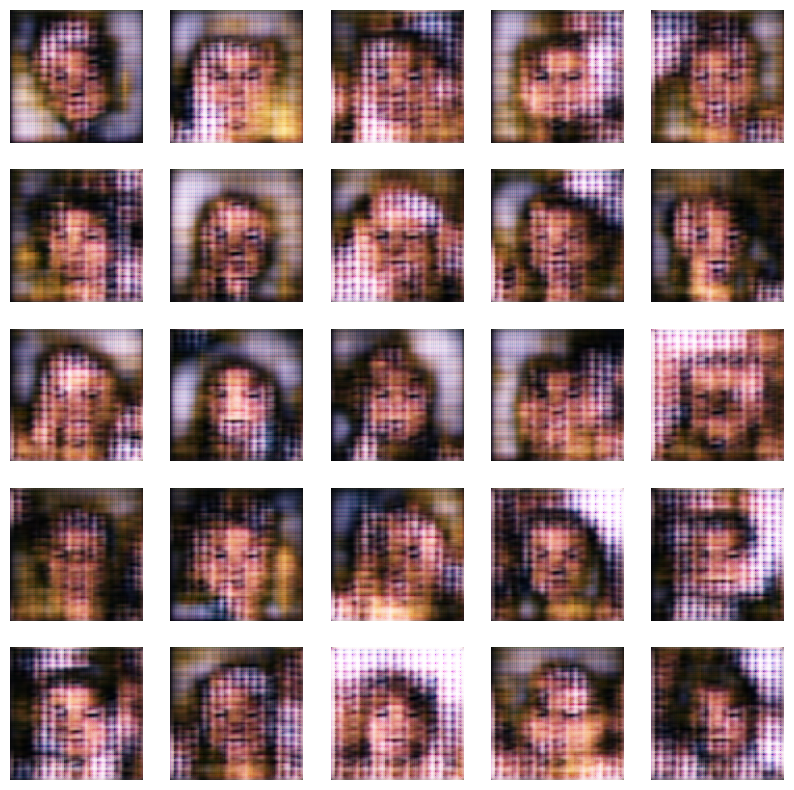

Total time for training 10 epochs is 14642.115135908127 sec


In [85]:
discriminator = define_discriminator()
generator = define_generator(latent_dim)

gan = define_gan(generator, discriminator)

train(generator, discriminator, gan, dataset, latent_dim, n_epoch, batch_size)


## 4. Reflexion sobre la sesion teorica y el laboratorio